# Fully connected neural network for the MNIST dataset using PyTorch

## Import libraries

In [355]:
import torch
from torchvision import datasets, transforms

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torch.utils.data.dataloader as dataloader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

#### Check for CUDA

In [356]:
if torch.cuda.is_available():
    device = "cuda"
    print("device=",device)

device= cuda


### Load data and define augmentation

In [357]:
transform = transforms.Compose([
    #transforms.CenterCrop(244),
    #transforms.RandomHorizontalFlip(p = 0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor()
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.MNIST('data', train=True,transform = transform, download = True)
test_data = datasets.MNIST('data', train = False,transform = transform, download = True  )

In [358]:
len(train_data), len(test_data), (train_data.train_labels)

(60000, 10000, tensor([5, 0, 4,  ..., 5, 6, 8]))

## Create validation set and data iterator

In [359]:
batch_size = 20

validation_size = 0.2
num_workers = 0
train_size = int(len(train_data) *(1- validation_size))
val_size = int(len(train_data)*validation_size)
#print(train_size, val_size)
train_indices = np.arange(len(train_data))
np.random.shuffle(train_indices)

split = int(np.floor(validation_size * len(train_data)))
print(train_size, val_size, len(train_indices), split)
train_idx, val_idx = train_indices[split:], train_indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, 
                                           sampler = train_sampler,num_workers = num_workers                                          
                                          )

val_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, 
                                           sampler = val_sampler,num_workers = num_workers                                          
                                          )

test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, 
                                           num_workers = num_workers                                          
                                          )

48000 12000 60000 12000


## Visualize one set of training data

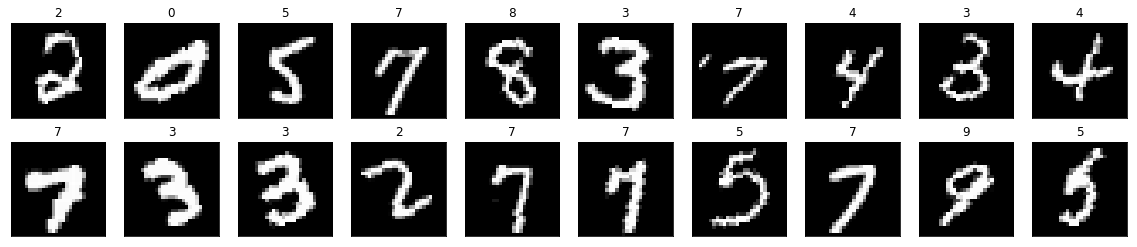

In [360]:
images, label = next(iter(train_loader))
images = images.numpy()
images[0], label[0]

#print(images[0].shape, label[0])

fig,ax = plt.subplots(2, 10, figsize = (20,4))
for i in range(batch_size):
#     print(i,int(i/10))
    a = ax[int(i/10),i%10]
    a.imshow(images[i].squeeze(), cmap = 'gray')
    a.set_title(label[i].item())
    a.set_xticks([])
    a.set_yticks([])
#     ax.show()

In [368]:
images[0].shape

(1, 28, 28)

## Define network architecture

* 4 fully connected layers
* Activation - RelU
* Dropout = 30%
* Model trained on GPU
* Model output - Log Softmax

In [371]:
in_size = 28*28

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = in_size, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 64)
        self.fc4 = nn.Linear(in_features = 64, out_features = 10)
        self.dropout = nn.Dropout(p = 0.3)
        
    def forward(self,x):
        x = x.view(-1,in_size)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x),dim = 1)
        return x

model = Net()
model.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3)
)

## Defining loss and optimizer

* Loss criterion - Negative Log Likelihood Loss
* Optimizer - Adam

In [372]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001 )

## Training and validation Step
* Epochs - 30
* Saving model if validation loss goes down

In [373]:
%%time
epochs = 30

running_train_loss = []
running_val_loss = []

v_loss_min = np.Inf
# accuracy = 0

for epoch in range(1,epochs+1):
    model.train()
    t_loss = 0
    v_loss = 0
    accuracy = 0
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        train_output = model(images)
        
        train_loss = criterion(train_output, labels)
        
        train_loss.backward()
        
        optimizer.step()
        
        t_loss += train_loss.item()
    
    with torch.no_grad():
        model.eval()
        
        for images, labels in val_loader:
            
            images, labels = images.cuda(), labels.cuda()

            val_output = model(images)
            
            val_loss = criterion(val_output, labels)
            v_loss += val_loss.item()
            
            _,pred_classes = torch.max(val_output,dim = 1)
            eq = pred_classes == labels #.view(*pred_classes.shape)
            accuracy += torch.mean(eq.type(torch.FloatTensor))
            
    
    t_loss = t_loss/(len(train_loader))
    v_loss = v_loss/(len(val_loader))
    
    running_train_loss.append(t_loss)
    running_val_loss.append(v_loss)
    
    
    print("Epoch {}\t..training loss: {:.5f}\t..validation_loss:{:.5f}\t..val accuracy:{:.3f}%".format(epoch,
                                                                                                  t_loss,
                                                                                                  v_loss,
                                                                                                 100*(accuracy.item()/len(val_loader))))
    
   # print("Raw Accuracy:", accuracy.item())
    if v_loss <= v_loss_min:
        print("validation loss decreased from {:.5f} to {:.5f}..saving moodel\n".format(v_loss_min, v_loss))
        torch.save(model.state_dict(),'mnist_nn_as.pt')
        v_loss_min = v_loss
    else:
        print("validation loss increased from {:.5f} to {:.5f}\n".format(v_loss_min, v_loss))
                 

Epoch 1	..training loss: 0.42337	..validation_loss:0.19910	..val accuracy:94.050%
Raw Accuracy: 564.3009033203125
validation loss decreased from inf to 0.19910..saving moodel

Epoch 2	..training loss: 0.22985	..validation_loss:0.14059	..val accuracy:95.725%
Raw Accuracy: 574.351318359375
validation loss decreased from 0.19910 to 0.14059..saving moodel

Epoch 3	..training loss: 0.19243	..validation_loss:0.12452	..val accuracy:96.342%
Raw Accuracy: 578.0512084960938
validation loss decreased from 0.14059 to 0.12452..saving moodel

Epoch 4	..training loss: 0.17704	..validation_loss:0.12984	..val accuracy:95.975%
Raw Accuracy: 575.8514404296875
validation loss increased from 0.12452 to 0.12984

Epoch 5	..training loss: 0.16904	..validation_loss:0.11043	..val accuracy:96.650%
Raw Accuracy: 579.9010009765625
validation loss decreased from 0.12452 to 0.11043..saving moodel

Epoch 6	..training loss: 0.16150	..validation_loss:0.10743	..val accuracy:96.609%
Raw Accuracy: 579.6513671875
validatio

#### Checking output

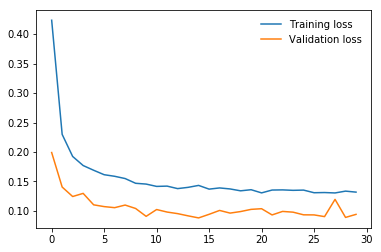

In [380]:
plt.plot(running_train_loss, label='Training loss')
plt.plot(running_val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [376]:
print(pred_classes, pred_classes.shape, labels.shape)
e = pred_classes == labels
print(e, torch.mean(e.type(torch.FloatTensor)))
print(len(train_data), len(train_loader), len(train_loader.dataset), len(val_loader), len(val_loader.dataset), val_loader.batch_size)
print(len(train_loader)*batch_size, len(val_loader)*batch_size)

tensor([6, 6, 6, 8, 7, 9, 5, 8, 9, 2, 4, 8, 8, 1, 0, 8, 4, 0, 9, 6],
       device='cuda:0') torch.Size([20]) torch.Size([20])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8) tensor(0.9000)
60000 2400 60000 600 60000 20
48000 12000


In [377]:
model.eval()
o = model(images)
o[0]
o1 = torch.exp(o)
a,b = torch.max(o,dim = 1)
print(o.shape,b)
print(labels)
print(b.shape,labels.shape)

tensor([-1.6701e+01, -2.5742e+01, -1.9578e+01, -2.4313e+01, -1.5131e+01,
        -1.0394e+01, -3.1471e-05, -2.6002e+01, -1.4223e+01, -2.2070e+01],
       device='cuda:0', grad_fn=<SelectBackward>)

In [279]:
model(images)[0], torch.exp(model(images)[0])

(tensor([-2.3537, -2.2997, -2.3043, -2.2335, -2.3796, -2.4189, -2.3206, -2.2381,
         -2.2083, -2.2894], device='cuda:0', grad_fn=<SelectBackward>),
 tensor([0.0950, 0.1003, 0.0998, 0.1072, 0.0926, 0.0890, 0.0982, 0.1067, 0.1099,
         0.1013], device='cuda:0', grad_fn=<ExpBackward>))

In [381]:
x = b == labels
print(x)
torch.mean(x.type(torch.FloatTensor))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8)


tensor(0.9000)

## Check on test set

In [382]:
class_correct = [0. for x in range(10)]
class_totals = [0. for x in range(10)]
c = 0
with torch.no_grad():
    c += 1
    model.eval()
    for data, labels in test_loader:
        data, labels = data.cuda(), labels.cuda()
        log_ps = model(data)
        test_output = torch.exp(log_ps)
        _,class_pred = torch.max(test_output, dim = 1)
#         class_pred = class_pred.cpu()
#         labels = labels.cpu()
        labels[i]

        if c > 2:
            break
        
        for i in range(batch_size):
            #print(class_pred[i])
            label = labels[i].item()
            if class_pred[i].item() == label:
                class_correct[label] += 1
            class_totals[label] += 1
            #print(label, class_pred[i].item())

for i in range(10):
    print("Accuracy of class {}: {}%".format(i,100*class_correct[i]/class_totals[i]))

total_correct = np.sum(class_correct)
total = np.sum(class_totals)
print("\nTotal Accuracy = {:.2f}%".format(100* total_correct/total)) 
print("total correct {} out of {}".format(total_correct,total))    

Accuracy of class 0: 99.38775510204081%
Accuracy of class 1: 99.20704845814979%
Accuracy of class 2: 97.57751937984496%
Accuracy of class 3: 97.42574257425743%
Accuracy of class 4: 97.25050916496944%
Accuracy of class 5: 94.84304932735427%
Accuracy of class 6: 98.32985386221294%
Accuracy of class 7: 97.27626459143968%
Accuracy of class 8: 97.63860369609856%
Accuracy of class 9: 96.72943508424183%

Total Accuracy = 97.61%
total correct 9761.0 out of 10000.0


### Checking output on one image

(28, 28)


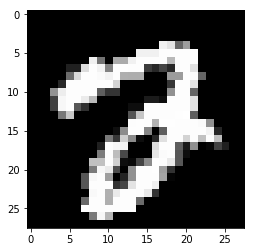

In [383]:
with torch.no_grad():
    output = torch.exp(model(data[0]))
_,output_label = torch.max(output,1)
im = np.squeeze(data[0].cpu().numpy())
print(im.shape)
plt.imshow(im, cmap = 'gray')

### Visualizing output on one batch of test data

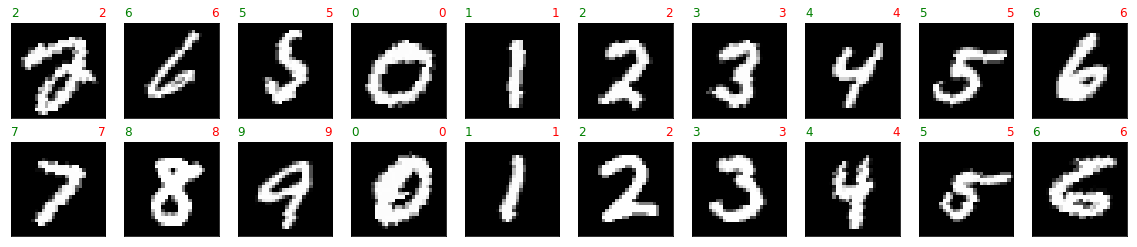

In [384]:
with torch.no_grad():
    output_model = torch.exp(model(data))
    _,output_label = torch.max(output_model, 1)
output_label = output_label.cpu().numpy()
fig,ax = plt.subplots(2, 10, figsize = (20,4))
for i in range(batch_size):
#     print(i,int(i/10))
    a = ax[int(i/10),i%10]
    a.imshow(data[i].cpu().squeeze(), cmap = 'gray')
    a.set_title(labels[i].cpu().item(), loc = 'left', color = 'green')
    a.set_title(output_label[i], loc = 'right', color = 'red')
    a.set_xticks([])
    a.set_yticks([])

## End